# ToDO:
- Hook, dass die NB Outputs im pre-commit gecleared werden

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from google.cloud import bigquery as bq

# Import Data

In [8]:
def get_bq_table(table_id, file_path=None, project_id: str = "brain-flash-dev", dataset_id: str = "dagster_common"):
    client = bq.Client(project=project_id)
    table_ref = f"{project_id}.{dataset_id}.{table_id}"

    query = f"SELECT * FROM `{table_ref}`"
    df = client.query(query).to_dataframe()

    if file_path is not None:
        df.to_csv(file_path, index=False)
        print(f"DataFrame saved to {file_path}")
    
    return df

In [9]:
#get_bq_table("CN_data_to_fetch", file_path='data/twins_100.csv')

In [10]:
df = pd.read_csv('data/twins_100.csv')

### Developement

In [142]:
class InputData:
    def __init__(self, data: pd.DataFrame):
        self.data = data
        self.TEST_ITEM_COMMUNICATIONKEYS = self.data["TEST_ITEM_COMMUNICATIONKEY"].unique()
        self.TWIN_ITEM_COMMUNICATIONKEYS = self.data["TWIN_ITEM_COMMUNICATIONKEY"].unique()
        
    def prepare_data(self, num_twins: int, key: int) -> pd.DataFrame:

        #warning, when wanted num_twins higher than twin count
        #at one point i should check that the test length is the same as the twin max length
        # print out quick summary of the data (start date, end date etc)
        # beidees berechnen, nur eines zurückgeben

        if num_twins == 0:
            #case: test item
            df = self.data.loc[
                (self.data["TEST_ITEM_COMMUNICATIONKEY"] == key) & 
                (self.data["TEST_ITEM_COMMUNICATIONKEY"] == self.data["TWIN_ITEM_COMMUNICATIONKEY"]),
                ["CALENDAR_DATE", "TWIN_ITEM_COMMUNICATIONKEY", "ANSPRACHE"]
            ].reset_index(drop=True)
        else:
            #case: twin items
            df = self.data.loc[
                (self.data["TEST_ITEM_COMMUNICATIONKEY"] == key) & 
                (self.data["TEST_ITEM_COMMUNICATIONKEY"] != self.data["TWIN_ITEM_COMMUNICATIONKEY"]),
                ["CALENDAR_DATE", "TWIN_ITEM_COMMUNICATIONKEY", "ANSPRACHE"]
            ].reset_index(drop=True)

            # reduce to wanted number of twin items
            df = df.iloc[:, :5]

        df = df.pivot(index="CALENDAR_DATE", columns="TWIN_ITEM_COMMUNICATIONKEY", values="ANSPRACHE")

        #reconsider the method of this step
        print(f"There are {df.isna().sum().sum()} NaN values in the data which are replaced with 0s.")
        df.fillna(0, inplace=True)
        #print(df.head())
        return df

In [137]:
np.arange(15)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [72]:
class Sampling:
    def __init__(self, data: pd.DataFrame, num_samples: int = 1000, seed: int = 161):
        self.data = data
        self.n, self.col = self.data.shape
        self.num_samples = num_samples
        self.bootstrap_sums = np.zeros(self.num_samples)
        self.seed = seed
        np.random.seed(self.seed)

    def iid_bootstrap(self) -> pd.Series:

        for i in range(self.num_samples):
            row_indices = np.random.choice(self.n, size=self.n, replace=True)
            col_indices = np.random.choice(self.col, size=self.n, replace=True)
            
            # Faster retrieval using NumPy advanced indexing
            sampled_values = self.data.values[row_indices, col_indices]
            self.bootstrap_sums[i] = np.sum(sampled_values)

        return pd.Series(self.bootstrap_sums, name="Bootstrap_Sums")

    def lbb(self, B: float = 0.1, b: int = 7) -> pd.Series:

        #define number of blocks
        M = range(int(np.ceil(self.n/b)))

        for i in range(self.num_samples):
            bootstrap_sample = []
            
            #create vector of column indices for each block
            col_choice = np.random.choice(self.col, size=M, replace=True)
            #iterate number of blocks
            for m in M:
                #define valid neighborhood range
                J_1m = max(1, m*b-self.n*B)
                J_2m = min(self.n-b+1, m*b+self.n*B)

                #draw block starting index -> uses overlapping blocks
                I_m = np.random.randint(J_1m, J_2m, replace=True) #stimmen hier die grenzen?

                #draw block from sample series
                sampled_block = self.data.iloc[I_m-1:I_m+b, col_choice[m]] #consider 0 indexing by -1
                bootstrap_sample.extend(sampled_block)
                #shorten the samlpe series to match original ts length
                self.bootstrap_sums[i] = np.sum(bootstrap_sample[:self.n])
        
        #ggf shorten time series
        return  pd.Series(self.bootstrap_sums, name="Bootstrap_Sums")


In [128]:
np.random.randint(1, 10) # wenn immer nur eins rauskommt ist es witzlos mit relace=True

3

### Test Area

In [143]:
data = InputData(df)
test = data.prepare_data(0, 716679764)
twin = data.prepare_data(5, 716679764)

There are 0 NaN values in the data which are replaced with 0s.
There are 12 NaN values in the data which are replaced with 0s.


In [147]:
sampler = Sampling(test, num_samples=5000)
results_simple = sampler.iid_bootstrap()

In [148]:
results_lbb = sampler.lbb(B=0.1, b=7)

In [150]:
results_lbb

0     716679764
1     716679764
2     716679764
3     716679764
4     716679764
5     716679764
6     716679764
7     716679764
8     716679764
9     716679764
10    716679764
11    716679764
12    716679764
13    716679764
14    716679764
15    716679764
16    716679764
17    716679764
18    716679764
19    716679764
20    716679764
21    716679764
22    716679764
23    716679764
24    716679764
25    716679764
26    716679764
27    716679764
28    716679764
29    716679764
30    716679764
31    716679764
32    716679764
33    716679764
34    716679764
35    716679764
36    716679764
37    716679764
38    716679764
39    716679764
40    716679764
41    716679764
42    716679764
43    716679764
Name: Bootstrap_Sums, dtype: int64

<Axes: title={'center': 'IID Bootstrap'}, ylabel='Frequency'>

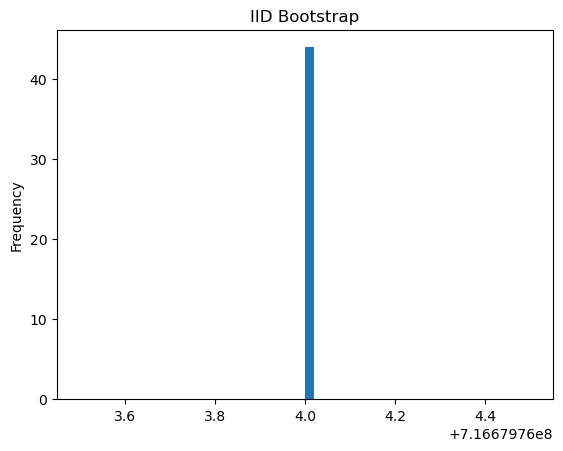

In [149]:
results_lbb.plot(kind="hist", bins=50, title="IID Bootstrap")

In [145]:
twin.sum().mean()

977.0

<Axes: ylabel='Frequency'>

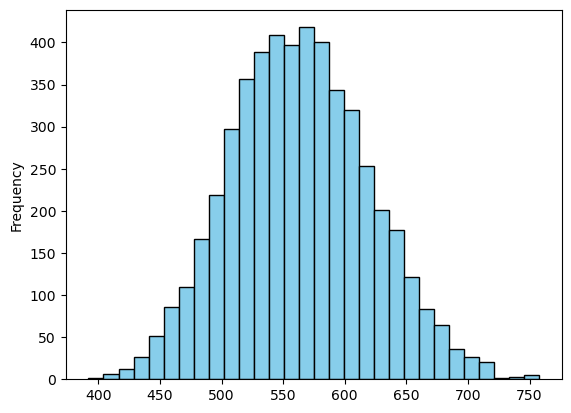

In [146]:
results.plot(kind="hist", bins=30, color="skyblue", edgecolor="black")

In [ ]:
#brauche ich eine Solution-Klasse oder schreibe ich die einfach immer in eine Datei?
class Evaluation():
    def __init (self):
        pass
    #MSE evaluation
    #Wasserstein evaluation

# Normality test
- tune number of iteration until distribution is normal

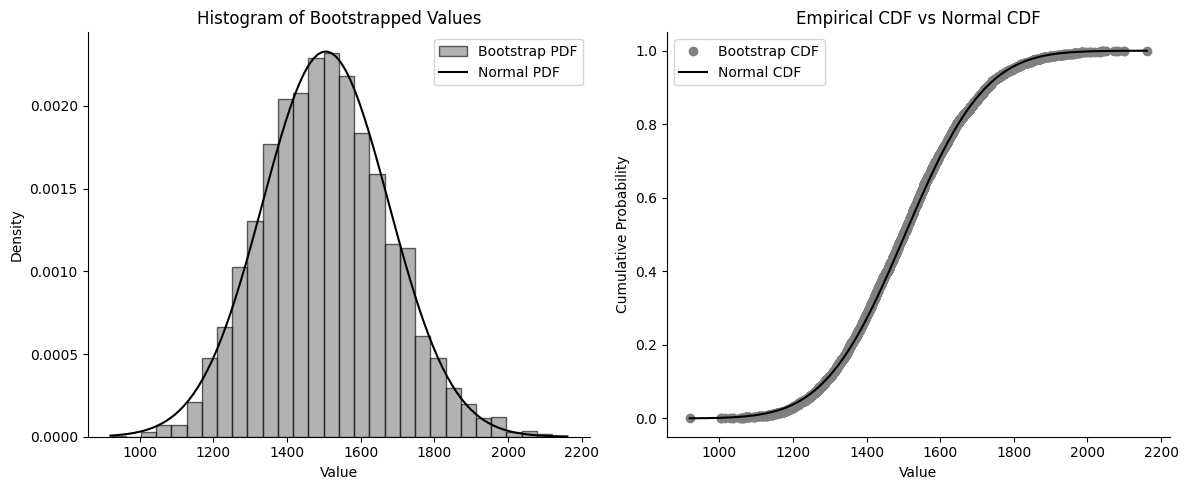

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram
ax1.hist(distr, bins=30, density=True, alpha=0.6, color='grey', edgecolor='black', label='Bootstrap PDF')
ax1.set_title('Histogram of Bootstrapped Values')
ax1.set_xlabel('Value')
ax1.set_ylabel('Density')

# Remove top and right spines for the histogram
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Calculate the normal PDF
x = np.linspace(min(distr), max(distr), 100)
normal_pdf = stats.norm.pdf(x, loc=np.mean(distr), scale=np.sqrt(np.var(distr, ddof = 1)))

# Plot the normal PDF
ax1.plot(x, normal_pdf, label='Normal PDF', color='black', linestyle='-')

# Plot the empirical CDF
data_sorted = np.sort(distr)
# Calculate the ECDF values
ecdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
ax2.plot(data_sorted, ecdf, marker='o', linestyle='none', color='grey', label='Bootstrap CDF')

# Remove top and right spines for the CDF
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Calculate the normal CDF
normal_cdf = stats.norm.cdf(x, loc=np.mean(distr), scale=np.sqrt(np.var(distr, ddof = 1)))

# Plot the normal CDF
ax2.plot(x, normal_cdf, label='Normal CDF', color='black', linestyle='-')

ax2.set_title('Empirical CDF vs Normal CDF')
ax2.set_xlabel('Value')
ax2.set_ylabel('Cumulative Probability')

# Add legends
ax1.legend()
ax2.legend()

plt.tight_layout()
plt.savefig('plots/bootstrap_joint_distribution.svg')
plt.show()


In [6]:
#define alpha level
alpha = 0.05

In [7]:
_, p_value = stats.normaltest(distr)
print(p_value)

8.546987677552962e-09


In [8]:
_, p_value = stats.shapiro(distr)
print(p_value)

4.5215951590459825e-08
